# Implementing REINFORCE from scratch

This notebooks explores how to implement the REINFORCE policy gradient method using PyTorch. The goals are:

- Get a better understanding of (probabilistic) policy gradient methods versus (deterministic) action-value methods.
- Understand how to implement these ideas explicitly in PyTorch

We'll try to avoid getting stuck in too much theory; there are plenty of excellent resources out there:

- Reinforcement Learning: An Introduction by Sutton and Barto (2012)
- [David Silver's lecture notes on policy gradients](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf)

## What are policy gradient methods?

### Action-value methods
To understand policy gradient methods, let's first quickly go over action-value methods (such as Q-learning).
Briefly, these methods model the value of states (usually denoted using $V(s)$), or state-action pairs (usually denoted using $Q(s, a)$) explicitly. To decide what action to take at state $s$, we use the model of the world ($V$ or $Q$) to find the best action. To find the best action, we thus solve an optimization problem of the form:

$$ \text{action} = \arg\max_{\text{actions}} \text{reward}(\text{current state}, \text{action}) + \text{discount factor} * \text{value}(\text{new state}, \text{action})$$

This is simplification, as we might not know the new state exactly, but I think it captures the main ideas. Note the two characteristics that are important:

1. We model the value of 'the world' explicitly
2. The actions are deterministic functions of our model

### Policy gradient methods
In contrast, policy gradient methods skip the 'model of the world part', and work more directly with actions. In particular, we have a distribution of actions $\pi$ parametrized by $\theta$. We take actions by sampling from the policy distribution directly.

There are some nice benefits: we do not have to bother modeling the world, and thus this method is called 'model free'. Furthermore, some times deterministic policies are not optimal (think Rock-Paper-Scissors). Finally, when we are dealing with continuous actions, the optimization problem action-value methods face is daunting, while sampling from a continuous distribution is no different than sampling from a discrete distribution. 

That's all very exciting, but of course there are some downsides too: they are less straightforward to implement (and wrap your head around, if you're anything like me), and can take a long time to converge (or not converge at all..).

### PyTorch

PyTorch makes it very easy to implement reinforcement learning with the `reinforce` method, but that's a big black box. We can open the black box by going over the source code, but it's much more fun to implement things ourselves. Also that makes it much easier to play around with the code. The emphasis will be on clarity (hopefully) over performance. 

Also, we'll be solving some very simple problems; I put my little laptop through enough hardship as is, and who likes waiting for learning anyway? However, the code should be problem-agnostic. 

In [1]:
import gym
import numpy as np
import torch

import functools
import math
import random
import time


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
env = gym.make('CartPole-v1')

[2017-10-16 10:22:46,423] Making new env: CartPole-v1


In [3]:
def live(env, policy, max_iter=100, feature_function=lambda state, t: state):
    """ Live for an episode """
    state = feature_function(env.reset(), 0)
    
    sars = [state]
    for t in range(max_iter):
        action = policy(state, env.action_space)
        state, reward, is_done, _flags = env.step(action)
        state = feature_function(state, t)
        
        sars.append(action)
        sars.append(reward)
        sars.append(state)
        if is_done:
            break
        
    return sars

def add_time(state, t):
    return np.append(state, t/100)


## Some utility functions for plotting
def ema(seq, gamma=0.95):
    """ Exponentially weighted moving average """
    return functools.reduce(lambda a, x: a + [gamma * a[-1] + (1-gamma) * x], 
                            seq, [sum(seq[:5])/5])

def plot_rewards_per_episode(rewards, gamma=0.95, method_name=""):
    ema_rewards = ema(rewards, gamma)

    f, ax = plt.subplots(1, 1)
    ax.plot(ema_rewards, linestyle="-")
    ax.set_title("{} Reward per episode".format(method_name))
    ax.set_xlabel("episode")
    ax.set_ylabel("reward")
    return f, ax

In [4]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.linear(x)
    
class Perceptron(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.0):
        super(Perceptron, self).__init__()
        self.i2h = torch.nn.Linear(input_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        self.dropout_probability = dropout
        
    def forward(self, x):
        hidden = torch.nn.functional.relu(self.i2h(x))
        return torch.nn.functional.dropout(self.h2o(hidden), p=self.dropout_probability)

class DiscreteActor(torch.nn.Module):
    def __init__(self, model):
        super(DiscreteActor, self).__init__()
        self.model = model

    def forward(self, x):
        return torch.nn.functional.log_softmax(self.model(x))
    
    def action(self, x):
        log_probs = self.forward(x)
        return torch.multinomial(torch.exp(log_probs)).data[0]
    

In [5]:
def random_policy(state, action_space):
    """ Select randomly from the action space"""
    return action_space.sample()

def actor_policy(actor):
    """
    Return the policy returned by the actor
    """
    def policy(state, space):
        tensor = torch.autograd.Variable(torch.Tensor(state))
        return actor.action(tensor)
    
    return policy

In [6]:
def extract_sars(sars):
    """ return (state, action, reward, new_state) tuples """
    return [sars[(3*i):(3*i+4)] for i in range(len(sars) // 3)]

def discounted_future_rewards(rewards, discount=0.9):
    """
    For each SARS observation, compute the total discounted 
    rewards achieved from that observation onwards.
    
    For example, if the rewards are 1, 0, 2, then this function
    returns [2.62, 1.8, 2.0] when a discount factor of 0.9 is used
    """    
    current_reward = 0
    discounted_values_backwards = []
    for r in rewards[::-1]:
        current_reward = r + discount * current_reward
        discounted_values_backwards.append(current_reward)
        
    return discounted_values_backwards[::-1]
         

def total_reward(sars_pairs, discount=1):
    """ Return the total (discounted) rewards"""
    return sum(discount**t * r for t, (_, _, r, _) in enumerate(sars_pairs))

# REINFORCE

## Actor updates

In [7]:
def policy_gradient_update(actor, state, action, modifier, optimizer, entropy_regularization=0.0):
    """ 
    The policy gradient update for the actor 
    
    By encoding the modifier as a parameter,
    it is easy to consider other methods 
    besides the REINFORCE algorithm, where
    modifier equals the monte-carlo estimate of
    the value.
    """
    
    # negate rewards since we want to be maximizing
    log_action_probs = actor(state)
    log_likelihood_action = log_action_probs[action] * modifier
    
    # more entropy induces more exploration
    entropy = torch.sum(log_action_probs * torch.exp(log_action_probs))
    
    loss = -log_likelihood_action - entropy_regularization * entropy
    loss.backward()

    optimizer.step()
    actor.zero_grad()    

def reinforce_update(actor, state, action, value, optimizer, entropy_factor=0.0):
    """ 
    Use the Monte Carlo estimate of value to update the actor 
    """
    state = torch.autograd.Variable(torch.Tensor(state))
    policy_gradient_update(actor, state, action, 
                           value, 
                           optimizer,
                           entropy_factor)

In [8]:
reinforce_actor = DiscreteActor(Perceptron(5, 10, 2, dropout=0.0))
reinforce_actor_optimizer = torch.optim.Adam(reinforce_actor.parameters(), lr=1e-4)


In [9]:
n_episodes = 5000
total_rewards = []
discount = 0.9
entropy_factor = 1

## REINFORCE model
time_start = time.time()
for epi in range(n_episodes):
    # run a single episode
    episode_sars = live(env, actor_policy(reinforce_actor), feature_function=add_time)
    
    # update actor
    sars_pairs = extract_sars(episode_sars)
    rewards = [r for _, _, r, _ in sars_pairs]
    for sars, value in zip(sars_pairs, discounted_future_rewards(rewards, discount=discount)):
        state, action, _, _ = sars
        reinforce_update(reinforce_actor, state, action, value, 
                         reinforce_actor_optimizer, 
                         entropy_factor=entropy_factor)
    
    # quick hack to show progress
    if epi % 100 == 0:
        print(".", end="")

    total_rewards.append(total_reward(sars_pairs))

print("Learning took {:.1f} seconds".format(time.time() - time_start))

..................................................Learning took 448.5 seconds


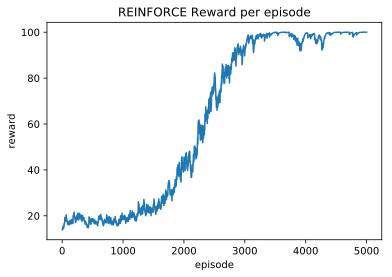

In [10]:
f, ax = plot_rewards_per_episode(total_rewards, gamma=0.95, method_name="REINFORCE")

# Continuous action space

Work in progress...